## Jupyter Notebook to analyze significant peaks in MZML file as found in OSW file

This notebook should work with the following generated files:

- Post-processed MZML experiments (total of 162) binned and bound to significant peaks
- Merged OSW table outlining significant peaks (QVALUE < 0.01) and total peaks (QVALUE < 1)

In [1]:
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

BASE_DIR = Path().resolve()
TSV_DIR = BASE_DIR / "data" / "tsv"
MZML_MAPPED_TSV_DIR = TSV_DIR / "mapped_mzml_to_osw_qval_01"


In [13]:
# Significant QVALUE OSW datapath
sig_qvalue_osw = TSV_DIR / "20220127_sig_qval_null_feature_ftrans_trans_score_ms2.tsv"
# Non-significant QVALUE OSW datapath
nonsig_qvalue_osw = TSV_DIR / "20220127_qval_null_feature_ftrans_trans_score_ms2.tsv"

# Significant 1/162 MZML
# mzml_1_162_sig_qvalue = MZML_MAPPED_TSV_DIR / '20220124_frame=25081_scan=452_qvalue_01.tsv'
# mzml_1_162_sig_qvalue = (
#     TSV_DIR
#     / "mapped_mzml_to_osw_qval_01_mz_window_20ppm"
#     / "merged_20220126_frame=22786_scan=452_qvalue_01.tsv"
# )
mzml_1_162_sig_qvalue = TSV_DIR / "merged_20220127_frame=22786_scan=452_qvalue_01.tsv"


In [14]:
# Load significant MZML 1/162 dataframe
mzml_1_162_df = pd.read_csv(mzml_1_162_sig_qvalue, sep="\t", chunksize=1_000_000)
mzml_1_162_df = next(mzml_1_162_df)


In [34]:
# Load chunk of significant OSW filepath (1,000,000 rows)
# sig_qvalue_osw_df = next(pd.read_csv(sig_qvalue_osw, sep='\t', chunksize=1_000_000))
sig_qvalue_osw_df = pd.read_csv(sig_qvalue_osw, sep="\t").drop(columns=["FEATURE_ID"])


In [35]:
print(mzml_1_162_df.shape, list(mzml_1_162_df))
print(sig_qvalue_osw_df.shape, list(sig_qvalue_osw_df))
merged_df = mzml_1_162_df.merge(sig_qvalue_osw_df, on="TRANSITION_ID")


(1000000, 10) ['FEATURE_ID', 'TRANSITION_ID', 'MZ', 'INTENSITY', 'TIC', 'IM', 'MS_LEVEL', 'RT', 'UNCHARGED_MASS', 'PERC_SIG_PEAKS']
(2594412, 25) ['SCORE', 'RANK', 'PVALUE', 'QVALUE', 'PEP', 'TRANSITION_ID', 'AREA_INTENSITY', 'TOTAL_AREA_INTENSITY', 'APEX_INTENSITY', 'RUN_ID', 'PRECURSOR_ID', 'EXP_RT', 'EXP_IM', 'NORM_RT', 'DELTA_RT', 'LEFT_WIDTH', 'RIGHT_WIDTH', 'PRODUCT_MZ', 'CHARGE', 'ORDINAL', 'DETECTING', 'IDENTIFYING', 'QUANTIFYING', 'LIBRARY_INTENSITY', 'DECOY']


In [36]:
# sig_qvalue_osw_df.head(10)[['FEATURE_ID', 'TRANSITION_ID']]
mzml_1_162_df.head(10)[["FEATURE_ID", "TRANSITION_ID"]]


,FEATURE_ID,TRANSITION_ID
0,-9223332315517110946,627706
1,-9223332315517110946,627705
2,-9223332315517110946,627706
3,-9223332315517110946,627704
4,-9223332315517110946,627704
5,-9223332315517110946,627704
6,-9223332315517110946,627703
7,-9223332315517110946,627703
8,-9223332315517110946,627706
9,-9223191966956721060,753918


In [101]:
# Select features within window
window_rt_df = merged_df[
    (merged_df["LEFT_WIDTH"] <= 2400.240718) & (merged_df["RIGHT_WIDTH"] >= 2400.240718)
]
window_rt_df.head(15)


,FEATURE_ID,TRANSITION_ID,MZ,INTENSITY,TIC,IM,MS_LEVEL,RT,UNCHARGED_MASS,PERC_SIG_PEAKS,...,LEFT_WIDTH,RIGHT_WIDTH,PRODUCT_MZ,CHARGE,ORDINAL,DETECTING,IDENTIFYING,QUANTIFYING,LIBRARY_INTENSITY,DECOY
1900,-9222832657421968659,419502,527.262902,39.000378,1317940.75,0.993548,2,2400.240718,1422.985447,77.7,...,2400.031006,2444.671875,527.2572,1,4,1,0,1,2955.501152,0
1905,-9222832657421968659,419502,527.262902,26.000776,1317940.75,0.995816,2,2400.240718,1422.985447,77.7,...,2400.031006,2444.671875,527.2572,1,4,1,0,1,2955.501152,0
1910,-9222832657421968659,419502,527.266495,32.000134,1317940.75,1.002619,2,2400.240718,1422.985447,77.7,...,2400.031006,2444.671875,527.2572,1,4,1,0,1,2955.501152,0
1915,-9222832657421968659,419502,527.255717,10.999724,1317940.75,0.986744,2,2400.240718,1422.985447,77.7,...,2400.031006,2444.671875,527.2572,1,4,1,0,1,2955.501152,0
1920,-9222832657421968659,419502,527.255717,31.000843,1317940.75,1.046803,2,2400.240718,1422.985447,77.7,...,2400.031006,2444.671875,527.2572,1,4,1,0,1,2955.501152,0
1925,-9222832657421968659,419502,527.252124,43.002117,1317940.75,1.009421,2,2400.240718,1422.985447,77.7,...,2400.031006,2444.671875,527.2572,1,4,1,0,1,2955.501152,0
1930,-9222832657421968659,419502,527.266495,123.997604,1317940.75,1.006020,2,2400.240718,1422.985447,77.7,...,2400.031006,2444.671875,527.2572,1,4,1,0,1,2955.501152,0
1935,-9222832657421968659,419502,527.262902,26.000776,1317940.75,1.007154,2,2400.240718,1422.985447,77.7,...,2400.031006,2444.671875,527.2572,1,4,1,0,1,2955.501152,0
1940,-9222832657421968659,419502,527.255717,44.002514,1317940.75,1.026418,2,2400.240718,1422.985447,77.7,...,2400.031006,2444.671875,527.2572,1,4,1,0,1,2955.501152,0
1945,-9222832657421968659,419502,527.259310,29.999756,1317940.75,1.035480,2,2400.240718,1422.985447,77.7,...,2400.031006,2444.671875,527.2572,1,4,1,0,1,2955.501152,0


In [113]:
# Demo block - check which columns to keep
cols = list(merged_df)
# RM from first half: PVALUE, PEP, UNCHARGED_MASS
first_half = cols[: int(len(cols) / 2)]
# RM from second half: DETECTING, IDENTIFYING, QUANTIFYING, DECOY
second_half = cols[int(len(cols) / 2) :]
# merged_df[second_half].head(30)


In [64]:
# Keeping useful columns from merged DF
cols_to_rm = ["PVALUE", "PEP", "UNCHARGED_MASS", "DETECTING", "IDENTIFYING", "QUANTIFYING", "DECOY"]
merged_df_tidy = merged_df.drop(columns=cols_to_rm)
# Drop duplicate rows
merged_df_tidy = merged_df_tidy.drop_duplicates()
print(merged_df_tidy.shape)
# merged_df_tidy.head(30)


(4886716, 27)


In [65]:
# What if we joined 'FEATURE_ID' with 'MZ' to create a unique key and keep unique cols
merged_df_tidy["FEATURE_ID_MZ"] = merged_df_tidy["FEATURE_ID"].astype(str) + merged_df_tidy[
    "MZ"
].astype(str)


In [66]:
# This is the number of found m/z
print(len(set(merged_df_tidy["FEATURE_ID_MZ"])))


593057


In [67]:
len(set(merged_df_tidy["FEATURE_ID"]))


56872

In [40]:
merged_df_tidy.dtypes


FEATURE_ID                int64
TRANSITION_ID             int64
MZ                      float64
INTENSITY               float64
TIC                     float64
IM                      float64
MS_LEVEL                  int64
RT                      float64
PERC_SIG_PEAKS          float64
SCORE                   float64
RANK                    float64
QVALUE                  float64
AREA_INTENSITY          float64
TOTAL_AREA_INTENSITY    float64
APEX_INTENSITY          float64
RUN_ID                    int64
PRECURSOR_ID              int64
EXP_RT                  float64
EXP_IM                  float64
NORM_RT                 float64
DELTA_RT                float64
LEFT_WIDTH              float64
RIGHT_WIDTH             float64
PRODUCT_MZ              float64
CHARGE                    int64
ORDINAL                   int64
LIBRARY_INTENSITY       float64
dtype: object

In [142]:
def unique(arr):
    unique_arr = tuple(set(arr))
    if len(unique_arr) == 1:
        return unique_arr[0]
    return unique_arr


# Aggregate data (attempt) using pivot table
# merged_df_test = merged_df_tidy[:1000]
merged_df_pivot = pd.pivot_table(
    window_rt_df.reset_index(),
    index=["TRANSITION_ID", "MZ"],
    aggfunc={
        "IM": lambda x: unique(x),
        "INTENSITY": lambda x: unique(x),
        "QVALUE": lambda x: unique(x),
        "NORM_RT": lambda x: unique(x),
        "EXP_RT": lambda x: unique(x),
        "EXP_IM": lambda x: unique(x),
        "FEATURE_ID": lambda x: list(x),
        # NOTE: you can use np.unique (more performant) but you CAN run into aggregation error...
    },
).reset_index()
# merged_df_pivot['UNIQUE_IM'] = merged_df_pivot['IM'] / 6
# merged_df_pivot['UNIQUE_IM'] = merged_df_pivot['UNIQUE_IM'].astype('int')
# set([len(x) for x in merged_df_pivot['FEATURE_ID']])
merged_df_pivot["FEATURE_ID"] = merged_df_pivot["FEATURE_ID"].apply(unique)
merged_df_pivot


,TRANSITION_ID,MZ,EXP_IM,EXP_RT,FEATURE_ID,IM,INTENSITY,NORM_RT,QVALUE
0,27402,476.217052,"(0.725884208658063, 0.719896889199867)","(2402.45, 2404.16)",-5119835767099351946,1.017354,48.00197,"(35.489327114387, 35.3999775835971)","(7.995952841791919e-06, 3.36407108213634e-06)"
1,27402,476.234123,"(0.725884208658063, 0.719896889199867)","(2402.45, 2404.16)",-5119835767099351946,0.99128,58.99824,"(35.489327114387, 35.3999775835971)","(7.995952841791919e-06, 3.36407108213634e-06)"
2,27405,543.269301,"(0.725884208658063, 0.719896889199867)","(2402.45, 2404.16)",-5119835767099351946,1.009421,25.001118,"(35.489327114387, 35.3999775835971)","(7.995952841791919e-06, 3.36407108213634e-06)"
3,27406,563.248055,"(0.725884208658063, 0.719896889199867)","(2402.45, 2404.16)",-5119835767099351946,"(1.0445391, 1.0332149)","(65.00062, 29.999756)","(35.489327114387, 35.3999775835971)","(7.995952841791919e-06, 3.36407108213634e-06)"
4,27406,563.255482,"(0.725884208658063, 0.719896889199867)","(2402.45, 2404.16)",-5119835767099351946,0.965185,51.99959,"(35.489327114387, 35.3999775835971)","(7.995952841791919e-06, 3.36407108213634e-06)"
...,...,...,...,...,...,...,...,...,...
4789,1678071,572.262430,0.78482,2393.1,-4050189523308238952,"(0.9980843, 1.0026195, 1.0105544)","(34.99797, 21.000942, 71.99853)",35.210522,0.00473
4790,1678071,572.266173,0.78482,2393.1,-4050189523308238952,"(1.0014857, 1.0286841)","(42.001728, 54.001713)",35.210522,0.00473
4791,1678071,572.269915,0.78482,2393.1,-4050189523308238952,"(1.0128212, 1.016221, 1.0207536, 1.0275513, 1....","(33.99822, 37.00041, 165.00461, 144.00151, 53....",35.210522,0.00473
4792,1678071,572.277401,0.78482,2393.1,-4050189523308238952,1.026418,60.99984,35.210522,0.00473


In [143]:
merged_df_pivot[merged_df_pivot["FEATURE_ID"] == -8312574784079845815]


,TRANSITION_ID,MZ,EXP_IM,EXP_RT,FEATURE_ID,IM,INTENSITY,NORM_RT,QVALUE


In [144]:
merged_df_tidy[merged_df_tidy["FEATURE_ID"] == -8312574784079845815]


,FEATURE_ID,TRANSITION_ID,MZ,INTENSITY,TIC,IM,MS_LEVEL,RT,PERC_SIG_PEAKS,SCORE,...,EXP_IM,NORM_RT,DELTA_RT,LEFT_WIDTH,RIGHT_WIDTH,PRODUCT_MZ,CHARGE,ORDINAL,LIBRARY_INTENSITY,FEATURE_ID_MZ


In [145]:
test = pd.pivot_table(
    merged_df_pivot,
    index=["TRANSITION_ID"],
    aggfunc={
        "FEATURE_ID": lambda x: unique(x),
        "IM": lambda x: unique(x),
        "MZ": lambda x: unique(x),
        "INTENSITY": lambda x: unique(x),
        "QVALUE": lambda x: unique(x),
        "NORM_RT": lambda x: unique(x),
        "EXP_RT": lambda x: unique(x),
        "EXP_IM": lambda x: unique(x),
    },
).reset_index()
test


,TRANSITION_ID,EXP_IM,EXP_RT,FEATURE_ID,IM,INTENSITY,MZ,NORM_RT,QVALUE
0,27402,"(0.725884208658063, 0.719896889199867)","(2402.45, 2404.16)",-5119835767099351946,"(0.9912804, 1.0173542)","(48.00197, 58.99824)","(476.2341233383274, 476.217051568239)","(35.489327114387, 35.3999775835971)","(7.995952841791919e-06, 3.36407108213634e-06)"
1,27405,"(0.725884208658063, 0.719896889199867)","(2402.45, 2404.16)",-5119835767099351946,1.009421,25.001118,543.269301,"(35.489327114387, 35.3999775835971)","(7.995952841791919e-06, 3.36407108213634e-06)"
2,27406,"(0.725884208658063, 0.719896889199867)","(2402.45, 2404.16)",-5119835767099351946,"(0.965185, 1.0026195, (1.0445391, 1.0332149))","(51.99959, (65.00062, 29.999756), 55.9984)","(563.255481562593, 563.2480551024895, 563.2666...","(35.489327114387, 35.3999775835971)","(7.995952841791919e-06, 3.36407108213634e-06)"
3,27408,"(0.725884208658063, 0.719896889199867)","(2402.45, 2404.16)",-5119835767099351946,"(1.0479356, 1.0456713)","(48.999626, 46.999405)","(650.2809128875056, 650.2849026857058)","(35.489327114387, 35.3999775835971)","(7.995952841791919e-06, 3.36407108213634e-06)"
4,27411,"(0.725884208658063, 0.719896889199867)","(2402.45, 2404.16)",-5119835767099351946,0.999218,10.000413,778.361535,"(35.489327114387, 35.3999775835971)","(7.995952841791919e-06, 3.36407108213634e-06)"
...,...,...,...,...,...,...,...,...,...
1898,1678068,0.78482,2393.1,-4050189523308238952,"(1.0366126, (0.9912804, 1.0037532, 0.9924145))","((32.999866, 53.00184, 62.001118), 54.998394)","(486.2459559747238, 486.25630633730407)",35.210522,0.00473
1899,1678069,0.78482,2393.1,-4050189523308238952,"(1.000352, 1.056991, (1.0230197, 1.0298169), 1...","((36.00237, 55.9984), 83.00519, 38.000164, 55....","(458.2193618361845, 458.2160127022147, 458.226...",35.210522,0.00473
1900,1678070,0.78482,2393.1,-4050189523308238952,"(0.98787785, (0.99921817, 1.0252856), (0.99695...","(65.00062, (53.00184, 54.998394), (49.99782, 5...","(531.3015676018138, 531.3051739538869, 531.294...",35.210522,0.00473
1901,1678071,0.78482,2393.1,-4050189523308238952,"((1.0128212, 1.016221, 1.0207536, 1.0275513, 1...","((51.99959, 70.996315), (33.99822, 37.00041, 1...","(572.2624297378736, 572.2661725798661, 572.258...",35.210522,0.00473


In [95]:
merged_df_pivot.head(15)


,FEATURE_ID,MZ,EXP_IM,EXP_RT,IM,INTENSITY,NORM_RT,QVALUE
0,-9223234016384753589,414.209899,0.850342,1595.29,1.020754,25.001118,21.809228,0.000002
1,-9223234016384753589,561.278055,0.850342,1595.29,0.96632,25.001118,21.809228,0.000002
2,-9223191966956721060,703.336277,1.125955,2425.21,"[1.0241526, 1.0309496, 1.0343475, 1.0388775, 1...","[10.000413, 25.001118, 28.998962, 38.000164, 5...",35.760367,0.000005
3,-9223025810847936645,589.286050,0.998811,2562.34,"[0.950426, 1.0683067, 1.0717007]","[51.99959, 53.00184, 115.003174]",37.901709,0.000133
4,-9223025810847936645,698.361694,0.998811,2562.34,1.055859,72.99557,37.901709,0.000133
5,-9222887475392189835,1123.549783,1.020071,2257.98,1.028684,28.000488,32.742510,0.000002
6,-9222870108405128498,373.207352,1.233716,5206.53,1.036613,54.001713,82.185008,0.000008
7,-9222870108405128498,543.313063,1.233716,5206.53,0.959509,25.001118,82.185008,0.000008
8,-9222854012696124655,361.244703,0.906408,2062.76,"[0.9799372, 1.0660439]","[38.000164, 67.00009]",29.586655,0.000189
9,-9222854012696124655,490.287472,0.906408,2062.76,"[1.0060204, 1.009421, 1.0184875, 1.0581228, 1....","[25.001118, 26.999048, 45.999134, 48.00197, 54...",29.586655,0.000189


In [17]:
# func to compress nested list dynamically


def compress_list(l):
    concat = []
    for item in l:
        if hasattr(item, "__iter__"):
            concat.extend(item)
        else:
            concat.append(item)
    return concat


compress_list([[1, 2, 3], [1, 3, 10], 1, 2, [1, 2]])


[1, 2, 3, 1, 3, 10, 1, 2, 1, 2]

In [136]:
# import itertools

# pd.pivot_table(
#     test,
#     index=["FEATURE_ID"],
#     aggfunc={'IM': lambda x:list(itertools.chain.from_iterable(x))}
# )
test["IM_FLAT"] = test["IM"].apply(lambda x: sorted(compress_list(x)))
test["IM_COUNT"] = test["IM"].apply(lambda x: len(compress_list(x)))
test["MZ_COUNT"] = test["MZ"].apply(lambda x: len(compress_list(x)))
test["INTENSITY_FLAT"] = test["INTENSITY"].apply(lambda x: compress_list(x))
test["INTENSITY_COUNT"] = test["INTENSITY"].apply(lambda x: len(compress_list(x)))
test.head(30)


,FEATURE_ID,EXP_IM,EXP_RT,IM,INTENSITY,MZ,NORM_RT,QVALUE,IM_FLAT,IM_COUNT,MZ_COUNT,INTENSITY_FLAT,INTENSITY_COUNT
0,-6775308908234118876,1.057907,5507.80,"[[0.942476, 0.95950925, 1.0082875], [1.0139545...","[[184.01067, 43.002117, 68.9968], [51.99959, 1...","[712.3609075164428, 712.3650834372602, 712.369...",87.147653,0.006473,"[0.9413401, 0.942476, 0.9538325, 0.95950925, 0...",24,7,"[184.01067, 43.002117, 68.9968, 51.99959, 1804...",24
1,-6775291210586485110,0.934377,5878.06,"[1.0252856, 1.0377451, [0.9799372, 1.0060204],...","[57.00128, 71.99853, [57.998936, 12.999451], [...","[896.4592247265272, 896.4639093154269, 1067.52...",93.300327,0.000002,"[0.9572387, 0.9799372, 1.0060204, 1.0150878, 1...",9,6,"[57.00128, 71.99853, 57.998936, 12.999451, 49....",9
2,-6775270907737789265,1.103814,3280.50,"[1.0490676, 0.9856093, [0.9924145, 1.0026195],...","[12.999451, 12.999451, [33.99822, 59.99871], [...","[434.239900383151, 451.2595963815349, 451.2695...",50.040590,0.003443,"[0.96177965, 0.9810717, 0.9810717, 0.98334056,...",15,11,"[12.999451, 12.999451, 33.99822, 59.99871, 60....",15
3,-6775240238818139523,1.237584,5406.42,"[0.9788026, 1.0683067, 1.0150878, 1.016221, 0....","[42.001728, 10.999724, 39.000378, 12.00049, 38...","[405.1465943317044, 647.2601501214726, 647.264...",85.291000,0.000170,"[0.9788026, 0.99581647, 0.9980843, 0.99921817,...",13,11,"[42.001728, 10.999724, 39.000378, 12.00049, 38...",13
4,-6775179303489088024,0.969504,1872.35,"[1.0173542, 1.0082875, 1.0060204, 1.0649124, 1...","[83.00519, 67.00009, 10.999724, 59.99871, 20.0...","[372.26792320560696, 501.29607467065017, 687.3...",26.382784,0.000002,"[0.9810717, 0.9856093, 1.0026195, 1.0060204, 1...",11,11,"[83.00519, 67.00009, 10.999724, 59.99871, 20.0...",11
5,-6775113294987372681,1.146665,3643.40,"[0.99921817, 1.0173542, [0.9708597, 1.0354801]...","[28.000488, 38.000164, [10.000413, 54.998394],...","[505.2553289085112, 514.2844574669913, 514.291...",56.250891,0.000075,"[0.94474757, 0.9515615, 0.95269704, 0.9708597,...",16,11,"[28.000488, 38.000164, 10.000413, 54.998394, 2...",16
6,-6775062495742560311,1.109992,2670.43,"[1.009421, 1.0184875, [0.99468255, 1.016221, 0...","[23.999681, 68.9968, [104.99975, 48.00197, 83....","[372.18340247704725, 446.25483774601554, 446.2...",39.718075,0.000002,"[0.98220617, 0.98447496, 0.98901206, 0.9924145...",17,11,"[23.999681, 68.9968, 104.99975, 48.00197, 83.9...",17
7,-6774999826832388391,1.258483,5041.79,"[1.0705694, 1.0660439, 1.0207536, 1.0275513, 1...","[38.000164, 85.003914, 75.00122, 34.99797, 39....","[517.237209016571, 517.2407673456554, 517.2443...",79.397768,0.000336,"[0.95269704, 0.95269704, 0.9810717, 0.98334056...",22,15,"[38.000164, 85.003914, 75.00122, 34.99797, 39....",22
8,-6774968970663919830,1.271863,4455.21,"[[1.0377451, 1.0218867], [1.0343475, 1.0411422...","[[48.999626, 89.0055], [97.997086, 259.0109, 1...","[482.30019270901033, 482.3036287672727, 482.30...",69.764418,0.001843,"[1.000352, 1.0037532, 1.0037532, 1.0139545, 1....",31,9,"[48.999626, 89.0055, 97.997086, 259.0109, 165....",31
9,-6774909887127073605,0.803540,5321.02,"[1.016221, 1.0637809, [1.0264184, 1.0275513, 1...","[39.000378, 78.00484, [43.002117, 78.00484, 95...","[476.271682278833, 680.2426761253174, 851.4716...",84.056890,0.000565,"[1.016221, 1.0207536, 1.0230197, 1.0252856, 1....",12,7,"[39.000378, 78.00484, 43.002117, 78.00484, 95....",12


(1.0, 2.0, 1.5, 3.0, 4.0, 2.5, 1.3333333333333333, 5.0, 1.6666666666666667, 6.0, 3.5, 7.0, 2.3333333333333335, 15.0, 2.6666666666666665, 8.0, 4.5, 10.0, 1.25, 5.5, 1.75, 3.3333333333333335, 9.0, 12.0, 6.5, 8.5, 2.25, 16.0, 11.0, 3.6666666666666665, 13.0, 4.666666666666667, 9.5, 18.0, 2.75, 4.333333333333333, 25.0, 6.666666666666667, 17.0, 1.4, 6.333333333333333, 1.2, 5.666666666666667, 11.5, 36.0, 3.25, 5.333333333333333, 7.666666666666667, 22.0, 7.5, 19.0, 1.8, 18.5, 2.2, 2.4, 1.6, 4.75, 3.75, 2.6, 10.5, 20.0, 14.0, 7.333333333333333, 13.5, 9.333333333333334, 8.333333333333334, 1.1666666666666667, 3.6, 5.4, 5.75, 6.25, 9.666666666666666, 3.2, 2.8, 20.5) (142391, 37902, 16692, 13356, 7190, 4918, 3666, 2953, 2351, 1806, 1640, 887, 710, 704, 643, 602, 592, 495, 396, 350, 270, 243, 243, 203, 197, 148, 127, 118, 102, 93, 85, 85, 79, 78, 59, 50, 45, 43, 31, 28, 27, 25, 24, 24, 23, 23, 18, 16, 15, 14, 14, 13, 13, 13, 11, 10, 7, 7, 7, 7, 7, 6, 6, 5, 4, 3, 3, 3, 3, 3, 3, 1, 1, 1, 1)


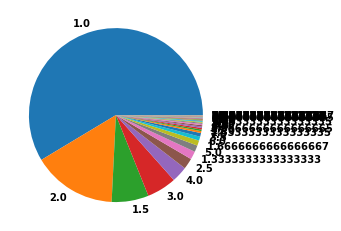

In [97]:
# Get ratio of IM per MZ reads PER feature ID

test["IM/MZ"] = test["IM_COUNT"] / test["MZ_COUNT"]
labels, counts = zip(*test["IM/MZ"].value_counts().iteritems())
print(labels, counts)

plt.pie(counts, labels=labels)
plt.show()


(1, 2, 3, 4, 5, 6) (162213, 64340, 14154, 2061, 158, 6)


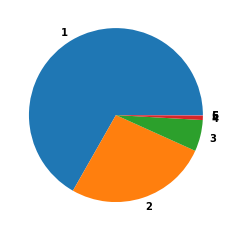

In [98]:
# Get MZ reads PER feature ID

labels, counts = zip(*test["MZ_COUNT"].value_counts().iteritems())
print(labels, counts)

plt.pie(counts, labels=labels)
plt.show()


In [21]:
# Percentage of features had one MZ?

print(len(test[test["MZ_COUNT"] == 1]) / len(test["MZ_COUNT"]))


0.6677300643801558


(1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 11, 12, 16, 13, 17, 14, 18, 19, 20, 26, 25, 23, 22, 21, 36, 37, 28, 27, 30, 24, 39, 29, 41, 32) (109169, 57225, 31176, 17991, 10244, 5658, 3422, 2107, 1336, 1097, 765, 604, 454, 355, 299, 203, 181, 171, 127, 60, 59, 51, 43, 34, 28, 23, 13, 10, 8, 8, 4, 4, 1, 1, 1)


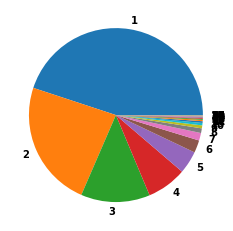

In [99]:
# Get IM reads PER feature ID

labels, counts = zip(*test["IM_COUNT"].value_counts().iteritems())
print(labels, counts)

plt.pie(counts, labels=labels)
plt.show()


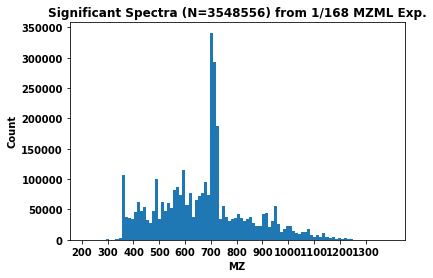

In [100]:
mz = merged_df_tidy["MZ"]
plt.hist(mz, bins=100)
plt.title(f"Significant Spectra (N={merged_df_tidy.shape[0]}) from 1/168 MZML Exp.")
plt.xlabel("MZ")
plt.xticks(np.arange(200, max(mz) + 1, 100.0))
plt.ylabel("Count")
plt.show()


In [24]:
# Check if intensity correlates with MZ count
zip_mz_int = zip(merged_df_tidy["MZ"], merged_df_tidy["INTENSITY"])
sorted(list(set(zip_mz_int)), key=lambda x: x[1], reverse=True)[:20]

# CONCLUSION - THOSE PEAKS WITH HIGH INTENSITY ARE PICKED UP AS SIGNIFICANT BY OPENSWATH


[(712.3692593580776, 3098.1677),
 (711.8640596622589, 3098.1677),
 (712.3734353459661, 2775.8425),
 (712.3692593580776, 2705.0085),
 (712.3692593580776, 2658.9072),
 (712.3692593580776, 2504.1357),
 (712.3692593580776, 2501.871),
 (712.3692593580776, 2468.1467),
 (712.3692593580776, 1986.1256),
 (711.8640596622589, 1959.0972),
 (712.3692593580776, 1852.933),
 (712.3692593580776, 1815.9409),
 (712.3734353459661, 1683.0225),
 (712.3692593580776, 1572.9907),
 (712.8704608717943, 1364.9949),
 (712.8662834754103, 1305.9509),
 (712.8662834754103, 1255.9382),
 (712.3692593580776, 1232.929),
 (712.8704608717943, 1070.0092),
 (712.8662834754103, 1062.9753)]

In [35]:
# Fetch MZ as written in summarized file
mz_arr_flat = compress_list(test["MZ"])
print(len(mz_arr_flat))
print(len(merged_df_tidy["MZ"]))


342425
3548556


In [103]:
np.array_split(merged_df_tidy, 100)


[                FEATURE_ID          MZ   INTENSITY         TIC        IM  \
 0     -5580699978540555130  212.103361  109.004005  1317940.75  1.015088   
 1     -5580699978540555130  212.103361  109.004005  1317940.75  1.015088   
 2     -5580699978540555130  212.103361  109.004005  1317940.75  1.015088   
 3     -5580699978540555130  212.103361  109.004005  1317940.75  1.015088   
 4     -5580699978540555130  212.103361  109.004005  1317940.75  1.015088   
 ...                    ...         ...         ...         ...       ...   
 35481  3774573086632569166  357.176253   31.000843  1317940.75  1.042275   
 35482  3774573086632569166  357.176253   31.000843  1317940.75  1.042275   
 35483  3774573086632569166  357.176253   31.000843  1317940.75  1.042275   
 35484  3774573086632569166  357.176253   51.999590  1317940.75  1.077356   
 35485  3774573086632569166  357.176253   51.999590  1317940.75  1.077356   
 
        MS_LEVEL           RT  PERC_SIG_PEAKS     SCORE  RANK  ...    EXP_

In [654]:
# Double check how many features are assigned to the same MZ spectrum
x = merged_df_tidy[merged_df_tidy["MZ"] > 240.134317]
y = x[x["MZ"] < 240.134319]
y


,FEATURE_ID,MZ,INTENSITY,TIC,IM,MS_LEVEL,RT,PERC_SIG_PEAKS,SCORE,RANK,...,EXP_IM,NORM_RT,DELTA_RT,LEFT_WIDTH,RIGHT_WIDTH,PRODUCT_MZ,CHARGE,ORDINAL,LIBRARY_INTENSITY,FEATURE_ID_MZ
0,33623715276931805,240.134317,54.001713,1317940.75,1.019621,2,2400.240718,8.73,3.481614,1.0,...,0.908809,28.753321,24.027811,1997.591675,2022.590942,240.1343,1,3,1580.552908,33623715276931805240.13431748266171
1,33623715276931805,240.134317,54.001713,1317940.75,1.019621,2,2400.240718,8.73,3.481614,1.0,...,0.908809,28.753321,24.027811,1997.591675,2022.590942,534.2704,1,4,10000.000000,33623715276931805240.13431748266171
2,33623715276931805,240.134317,54.001713,1317940.75,1.019621,2,2400.240718,8.73,3.481614,1.0,...,0.908809,28.753321,24.027811,1997.591675,2022.590942,633.3389,1,5,6855.534709,33623715276931805240.13431748266171
3,33623715276931805,240.134317,54.001713,1317940.75,1.019621,2,2400.240718,8.73,3.481614,1.0,...,0.908809,28.753321,24.027811,1997.591675,2022.590942,746.4229,1,6,7039.399625,33623715276931805240.13431748266171
4,33623715276931805,240.134317,54.001713,1317940.75,1.019621,2,2400.240718,8.73,3.481614,1.0,...,0.908809,28.753321,24.027811,1997.591675,2022.590942,883.4818,1,7,4844.287822,33623715276931805240.13431748266171
5,33623715276931805,240.134317,54.001713,1317940.75,1.019621,2,2400.240718,8.73,3.481614,1.0,...,0.908809,28.753321,24.027811,1997.591675,2022.590942,980.5346,1,8,5474.671670,33623715276931805240.13431748266171
6,7414481149340925292,240.134317,54.001713,1317940.75,1.019621,2,2400.240718,8.73,3.040386,1.0,...,0.909596,28.717232,20.772234,2005.093140,2028.313110,240.1343,1,3,1580.552908,7414481149340925292240.13431748266171
7,7414481149340925292,240.134317,54.001713,1317940.75,1.019621,2,2400.240718,8.73,3.040386,1.0,...,0.909596,28.717232,20.772234,2005.093140,2028.313110,534.2704,1,4,10000.000000,7414481149340925292240.13431748266171
8,7414481149340925292,240.134317,54.001713,1317940.75,1.019621,2,2400.240718,8.73,3.040386,1.0,...,0.909596,28.717232,20.772234,2005.093140,2028.313110,633.3389,1,5,6855.534709,7414481149340925292240.13431748266171
9,7414481149340925292,240.134317,54.001713,1317940.75,1.019621,2,2400.240718,8.73,3.040386,1.0,...,0.909596,28.717232,20.772234,2005.093140,2028.313110,746.4229,1,6,7039.399625,7414481149340925292240.13431748266171


In [643]:
# ANSWER THE QUESTION :: CAN A PEAK BE ASSIGNED TO MORE THAN ONE FEATURE?

mz_centric = pd.pivot_table(
    merged_df_tidy, index=["MZ", "FEATURE_ID"], aggfunc={"FEATURE_ID": np.unique, "MZ": np.unique}
).rename(columns={"FEATURE_ID": "ID", "MZ": "_MZ"})
mz_centric

# mz_centric_2 = pd.pivot_table(
#    mz_centric,
#    index=['MZ'],
#    aggfunc={'ID': lambda x:list(x)}
# ).rename(columns={'ID': 'FEATURE_ID'})
# mz_centric_2['FI_COUNT'] = mz_centric_2['FEATURE_ID'].apply(lambda x: len(compress_list(x)))

# mz_centric_2['MZ'] = mz_centric_2.index
# mz_centric_2

# plt.bar(mz_centric_2['MZ'], mz_centric_2['FI_COUNT'])
# plt.show()

## Get Features per MZ
# labels, counts = zip(*mz_centric_2['FI_COUNT'].value_counts().iteritems())
# print(labels, counts)

# plt.pie(counts, labels = labels)
# plt.show()


ID          _MZ
MZ          FEATURE_ID                                            
240.134317  -2705134088862105420 -2705134088862105420   240.134317
             33623715276931805      33623715276931805   240.134317
             7414481149340925292  7414481149340925292   240.134317
244.092799  -8312574784079845815 -8312574784079845815   244.092799
            -6405525529414504260 -6405525529414504260   244.092799
...                                               ...          ...
1337.648422 -1345227877448078737 -1345227877448078737  1337.648422
             2704658699290795648  2704658699290795648  1337.648422
             5197323735562610338  5197323735562610338  1337.648422
             6009431033176693445  6009431033176693445  1337.648422
1389.668463  745180188279589795    745180188279589795  1389.668463

[35912 rows x 2 columns]

In [638]:
len(mz_centric_2[mz_centric_2["FI_COUNT"] == 1]) / mz_centric_2.shape[0]


0.08

In [567]:
merged_df_tidy[merged_df_tidy["FEATURE_ID"] == 7516195912228066749]["PRODUCT_MZ"]


0      200.1030
1      271.1401
2      399.1987
3      498.2671
4      627.3097
5     1463.6801
6      200.1030
7      271.1401
8      399.1987
9      498.2671
10     627.3097
11    1463.6801
Name: PRODUCT_MZ, dtype: float64

In [496]:
# Is there a correlation with intensity and QVALUE?
merged_df_tidy["EXP_RT"].corr(merged_df_tidy["MZ"])


0.06844548959197988

In [454]:
from collections import Counter

x = Counter(merged_df_tidy["MZ"])
dict(sorted(x.items(), key=lambda item: item[1], reverse=True))


{717.3892056662297: 52740,
 357.17625281984147: 44808,
 702.41541568793: 40590,
 594.2873063838515: 30912,
 703.3985195773494: 24360,
 703.3362774242454: 21480,
 720.3718390510872: 21168,
 703.373622340509: 18468,
 683.3475388151172: 18396,
 514.2986502052446: 17670,
 723.3312039564504: 16800,
 404.2495528697559: 16632,
 490.28747191560615: 15180,
 702.4029757887675: 14904,
 595.2832224176677: 14700,
 661.3514894437288: 14304,
 358.16159460736714: 14172,
 703.3611739233024: 13716,
 712.3734353459661: 13320,
 446.2614481506656: 13308,
 566.29329651392: 12762,
 712.3984912732974: 12480,
 719.3685475983609: 11952,
 701.3584135404438: 11268,
 418.2286188038439: 11040,
 387.1883605823552: 10980,
 579.324340760397: 10962,
 390.1989732604511: 10488,
 655.3418261586586: 10470,
 700.3518932795047: 10368,
 717.4143496580642: 10242,
 951.478651031562: 10128,
 493.243579909918: 9936,
 709.3449162636022: 9702,
 431.2357916676895: 9600,
 361.2447031515288: 9444,
 702.3780961916563: 9378,
 720.367639

In [198]:
pd.pivot_table(merged_df_pivot, index=["ID"], aggfunc={"_MZ": len, "IM": np.size})


,IM,_MZ
ID,,
-9223234016384753589,2,2
-9222854012696124655,2,2
-9222392951750703420,1,1
-9222302006162991364,1,1
-9221957991851146809,1,1
...,...,...
9222707227348518554,1,1
9223023428199093275,1,1
9223087708840047210,2,2


In [168]:
print(merged_df_tidy[merged_df_tidy["FEATURE_ID"] == -9223234016384753589])


                 FEATURE_ID          MZ  INTENSITY         TIC        IM  \
198624 -9223234016384753589  414.209899  25.001118  1317940.75  1.020754   
198625 -9223234016384753589  414.209899  25.001118  1317940.75  1.020754   
198626 -9223234016384753589  414.209899  25.001118  1317940.75  1.020754   
198627 -9223234016384753589  414.209899  25.001118  1317940.75  1.020754   
198628 -9223234016384753589  414.209899  25.001118  1317940.75  1.020754   
198629 -9223234016384753589  414.209899  25.001118  1317940.75  1.020754   
198630 -9223234016384753589  561.278055  25.001118  1317940.75  0.966320   
198631 -9223234016384753589  561.278055  25.001118  1317940.75  0.966320   
198632 -9223234016384753589  561.278055  25.001118  1317940.75  0.966320   
198633 -9223234016384753589  561.278055  25.001118  1317940.75  0.966320   
198634 -9223234016384753589  561.278055  25.001118  1317940.75  0.966320   
198635 -9223234016384753589  561.278055  25.001118  1317940.75  0.966320   

        MS_

In [139]:
# Check how many peaks area associated with features
# features = set(merged_df_tidy['FEATURE_ID'])
# for feature in features:
#     print(feature, '---', len(merged_df[merged_df['FEATURE_ID'] == feature]))


In [80]:
mzml_1_162_df
print(sig_qvalue_osw_df["PRODUCT_MZ"][0], mzml_1_162_df["MZ"][0])


405.198 212.10336103240303


In [99]:
one_feature = list(set(merged_df["FEATURE_ID"]))[15]


In [100]:
set(merged_df[merged_df["FEATURE_ID"] == one_feature]["IM"])


{1.0037532, 1.0218867}

In [103]:
# # Print IM's found per feature identified
# for feature in list(set(merged_df['FEATURE_ID'])):
#     print(set(merged_df[merged_df['FEATURE_ID'] == feature]['IM']))


In [109]:
select_cols = [
    "FEATURE_ID",
    "MZ",
    "INTENSITY",
    "TIC",
    "IM",
    "MS_LEVEL",
    "RT",
    "UNCHARGED_MASS",
    "PERC_SIG_PEAKS",
    "QVALUE",
    "TRANSITION_ID",
    "AREA_INTENSITY",
    "TOTAL_AREA_INTENSITY",
    "APEX_INTENSITY",
    "PRECURSOR_ID",
    "EXP_RT",
    "EXP_IM",
    "NORM_RT",
    "DELTA_RT",
    "LEFT_WIDTH",
    "RIGHT_WIDTH",
    "PRODUCT_MZ",
    "CHARGE",
]
# merged_df[select_cols].head(50)


In [111]:
# 99.9983% of rows are unique.
print(merged_df.shape)
print(merged_df.drop_duplicates().shape)


(1442280, 34)
(1442256, 34)


In [114]:
merged_df[:3000].to_csv("test.csv")


In [379]:
# Drop cols: DETECTING, IDENTIFYING, QUANTIFYING, DECOY
print(merged_df.shape)
for col in list(merged_df):
    print(col, len(set(merged_df[col])))


(1442280, 34)
FEATURE_ID 96623
MZ 5543
INTENSITY 290
TIC 1
IM 138
MS_LEVEL 1
RT 1
UNCHARGED_MASS 1
PERC_SIG_PEAKS 1
SCORE 95258
RANK 5
PVALUE 7222
QVALUE 7222
PEP 7222
TRANSITION_ID 165782
AREA_INTENSITY 192748
TOTAL_AREA_INTENSITY 508277
APEX_INTENSITY 557457
RUN_ID 6
PRECURSOR_ID 27631
EXP_RT 86907
EXP_IM 96411
NORM_RT 96508
DELTA_RT 96622
LEFT_WIDTH 58771
RIGHT_WIDTH 58379
PRODUCT_MZ 44527
CHARGE 4
ORDINAL 23
DETECTING 1
IDENTIFYING 1
QUANTIFYING 1
LIBRARY_INTENSITY 137916
DECOY 1
